<a href="https://colab.research.google.com/github/fanurs/pytorch-notes/blob/main/notes/tut04_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main reason for having automatic differentiation (AD) in PyTorch is to perform gradient descent (GD). In this tutorial, we will look at how optimization can be performed iteratively. This is exactly the same piece of mathematics used for "training" an artificial neural network (ANN).

# Gradient descent (GD)

As always, we learn from examples.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch as th

## A simple two-dimensional example

Consider a two-variable function,
$$ f(x_0, x_1) = x_0\sin(x_0^2) + 2x_1\sin(x_1^2) \ . $$
Our goal is to minimize $f$ over the rectangular domain
$$ \mathcal{D} \equiv \{(x_0, x_1) : x_0\in[0, 3] \ \wedge \ x_1\in[0, 3] \} \ . $$

Here is a contour plot of the function:

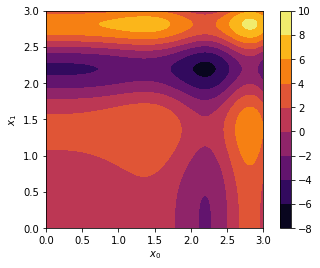

In [2]:
def surface(x0, x1):
    return x0 * th.sin(x0**2) + 2 * x1 * th.sin(x1**2)
xx, yy = th.meshgrid(th.linspace(0, 3, 300), th.linspace(0, 3, 300), indexing='ij')
zz = surface(xx, yy)

def draw_contour():
    cb = plt.contourf(xx, yy, zz, cmap=plt.cm.inferno)
    plt.colorbar(cb)
    plt.gca().set_aspect('equal')
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$')
draw_contour()
plt.show()

It is not hard to see that the lowest point over $\mathcal{D}$ is somewhere around $x_0 \approx 2.2$ and $x_1 \approx 2.2$. But how can we use gradient descent to find that?

## The idea

The idea of gradient descent is pretty straightforward. First, we pick an initial point. The choice of the initial point is usually very crucial, but for now let us simply start with the center point of $\mathcal{D}$,
$$ \mathbf{x}_0 \equiv \begin{bmatrix}1.5\\1.5\end{bmatrix} \ . $$
Next, we evaluate the gradient at $\mathbf{x}_0$. From [basic calculus](http://aleph0.clarku.edu/~djoyce/ma131/directional.pdf), we know that $\nabla f(\mathbf{x}_0)$ gives the steepest _ascent_, and hence $-\nabla f(\mathbf{x}_0)$ gives the steepest _descent_. Since our goal is to minimize $f$, we naturally want to step toward the direction of steepest descent. This suggests the next point to be
$$ \mathbf{x}_1 = \mathbf{x}_0 - \gamma\cdot\nabla f(\mathbf{x}_0) $$
such that
$$ f(\mathbf{x}_1) \le f(\mathbf{x}_0) \ . $$
Here, $\gamma > 0$ is called the "learning rate". Typically, the value of $\gamma$ is smaller than one. The role of a learning rate is for us to control the "step" size from $\mathbf{x}_0$ to $\mathbf{x}_1$. If the learning rate is too small, $\mathbf{x}_0$ and $\mathbf{x}_1$ would be very close to each other, and $f$ would have barely decreased, resulting in slow minimization process. On the other hand, if the learning rate is too large, we may have stepped over the minimum point between $\mathbf{x}_0$ and $\mathbf{x}_1$, and could result in $f(\mathbf{x}_1) > f(\mathbf{x}_0)$. In practice, learning rate $\gamma$ is determined empirically. A good value to start with is $\gamma = 0.01$.

To perform gradient descent, we simply repeat the above procedure as many times as needed according to
$$ \mathbf{x}_{n+1} = \mathbf{x}_n - \gamma\cdot\nabla f(\mathbf{x}_n) \ , $$
where $n = 0, 1, \ldots$.

## Implementation without an optimizer

Let us implement this simple algorithm below without using any built-in optimizer from PyTorch:

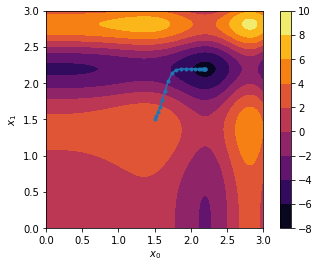

In [3]:
x_init = [1.5, 1.5]
x = th.tensor(x_init)
learning_rate = 0.01

trace = [th.clone(x.detach())] # store the initial point
for _ in range(20):
    x.requires_grad = True
    y = surface(*x)
    y.backward()
    with th.no_grad(): # disabling gradient descent
        x = x - learning_rate * x.grad
    trace.append(th.clone(x))
trace = th.stack(trace)

plt.plot(trace[:, 0], trace[:, 1], '.-')
draw_contour()
plt.show()

In this implementation, we have set $\gamma = 0.01$. We perform GD for 20 iterations. In each iteration, we update the parameters according to `x = x - learning_rate * x.grad`. Notice that this update is placed within the context manager `torch.no_grad()`. This has the effect of reseting the computation history before next loop. Lastly, to store the value of `x` in each loop, we need `torch.clone` to copy the entries. Otherwise, PyTorch tensor `x` will use the same memory, so values from the previous loop will be erased after updating `x`.

As we can see from the plot, the trace of gradient descent does slowly move toward the lowest point of $f$ over $\mathcal{D}$. In fact, the last point of `trace` has the following value:

In [4]:
trace[-1]

tensor([2.1925, 2.1945])

## Implementation with an optimizer

When training a neural network, there will be many more parameters that we need to tune. Implementing the optimizer from scratch would be tedious. Moreover, the gradient descent algorithm that we have described is just the most basic one. In practice, one may want to use some more sophisticated optimization algorithm to speed up the process, and avoid getting trapped in local minima. This is when PyTorch optimizers would be useful.

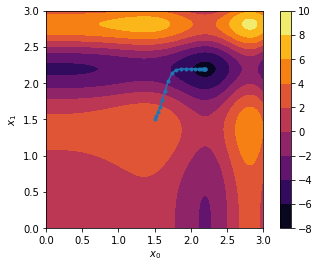

In [5]:
x_init = [1.5, 1.5]
x = th.tensor(x_init, requires_grad=True)
optimizer = th.optim.SGD([x], lr=0.01)

trace = [th.clone(x.detach())]
for _ in range(20):
    optimizer.zero_grad()
    y = surface(*x)
    y.backward()
    optimizer.step()
    trace.append(th.clone(x.detach()))
trace = th.stack(trace)

plt.plot(trace[:, 0], trace[:, 1], '.-')
draw_contour()
plt.show()

There are a few optimizers PyTorch provides under [`torch.optim`](https://pytorch.org/docs/stable/optim.html). We have used the stochastic gradient descent (SGD) implementation with zero momentum. If you check the [documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), SGD with zero momentum is just the ordinary GD algorithm that we had implemented without an optimizer. You can try comparing the traces from both implementation and verify that they are identical.

All PyTorch optimizers takes in an iterable of tensors that we want to tune. To update the parameters, in this case `x`, simply do `optimizer.step()`. Lastly, remember to reset the gradient of the optimizer to zero at the beginning of each loop. Otherwise your evaluation of the gradient would consist of gradient from the previous loops.

## Initial points

We had briefly mentioned the choice of initial points is important. To see why, we re-run the same algorithm, but with initial point $\mathbf{x}_0 = \begin{bmatrix}1.0\\1.5\end{bmatrix}$:

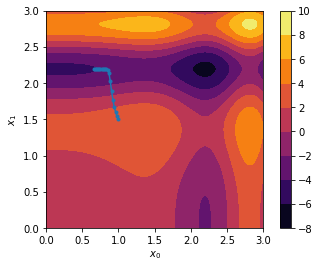

In [6]:
x_init = [1.0, 1.5]
x = th.tensor(x_init, requires_grad=True)
optimizer = th.optim.SGD([x], lr=0.01)

trace = [th.clone(x.detach())]
for _ in range(20):
    optimizer.zero_grad()
    y = surface(*x)
    y.backward()
    optimizer.step()
    trace.append(th.clone(x.detach()))
trace = th.stack(trace)

plt.plot(trace[:, 0], trace[:, 1], '.-')
draw_contour()
plt.show()

This time, the gradient descent traces from $\mathbf{x}_0$ toward a local minima around $(0.2, 2.2)$.

Depending on the problems you are solving, finding a local minimum instead of a global minimum may or may not be an issue. When optimizing (training) a neural network, it is usually very difficult, if not impossible, to guarantee finding a global minimum due to the vast number of parameters involved. In practice, as long as a local minimum can give satisfactory training result, we are happy. There are also techniques such as batch training and SGD (with non-zero momentum) to reduce the chance of getting stuck in a local minimum. Nevertheless, none of them can promise a global minimum.

## Learning rate

Learning rate is one of the most critical parameters in an optimizer. When the learning rate is too low, the training process will be very slow. When the learning rate is too high, the optimizer might skip over some minima by accident.

Here, we re-run the same algorithm with $\mathbf{x}_0 = \begin{bmatrix}1.5\\1.5\end{bmatrix}$, but with learning rate set to $\gamma = 0.05$.

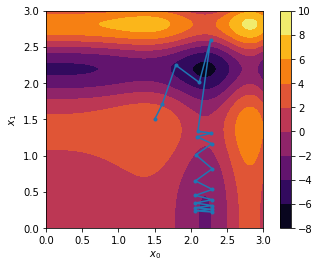

In [7]:
x_init = [1.5, 1.5]
x = th.tensor(x_init, requires_grad=True)
optimizer = th.optim.SGD([x], lr=0.05)

trace = [th.clone(x.detach())]
for _ in range(20):
    optimizer.zero_grad()
    y = surface(*x)
    y.backward()
    optimizer.step()
    trace.append(th.clone(x.detach()))
trace = th.stack(trace)

plt.plot(trace[:, 0], trace[:, 1], '.-')
draw_contour()
plt.show()

As we can see, the optimizer missed the global minimum, and eventually hopped onto a local minimum at around $(2.2, 0.2)$.

# Least square regression

Just to demonstrate how gradient descent can be used to solve any continuous optimization problems, we will look at a simple example from least square regression.

Consider a quadratic model (function):
$$ f(x; p_0, p_1, p_2) = p_0 + p_1 x + p_2 x^2 \ . $$
We are given $n$ pairs of $(x_i, y_i)$ data. The goal is to fit $f$ to $(x_i, y_i)$ using least squares method. Mathematically, we define a loss function,
$$ \mathcal{L}(p_0, p_1, p_2) \equiv \sum_{i=1}^n \left[y_i - f(x_i; p_0, p_1, p_2)\right]^2 \ , $$
which depends on $p_0, p_1, p_2$. We want to find the values for $p_0, p_1, p_2$ such that $\mathcal{L}$ is the smallest.

First, we prepare some synthetic data that we want to fit. We have the real model parametrized by
$$ (p_0, p_1, p_2) = (1, -2, 2) \ . $$
Some Gaussian noise has also been added to better simulate real world data such that
$$ Y \sim \mathcal{N}(f(X), \sigma^2) \ , $$
where $\sigma = 0.02$.

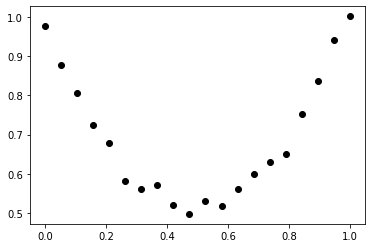

In [8]:
model = lambda x, p0, p1, p2: p0 + p1 * x + p2 * x**2
rand_gen = th.Generator()
rand_gen.manual_seed(0)
x = th.linspace(0, 1, 20)
y = th.normal(model(x, 1, -2, 2), 0.02, generator=rand_gen)
plt.scatter(x.detach(), y.detach(), color='black', zorder=100)
plt.show()

Next, we initialize the parameters to $(0, 0, 0)$. We will use another optimizer named "[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)", with learning rate set to $0.5$.

In [9]:
param = th.tensor([0.0, 0.0, 0.0], requires_grad=True)
optimizer = th.optim.Adam([param], lr=0.5)

Lastly, we iteratively minimize the loss function $\mathcal{L}$ like before, and plot out the quadratic in each iteration.

In [10]:
def plot_curve(color):
    par = th.clone(param.detach())
    x_plt = th.linspace(0, 1, 100)
    plt.plot(x_plt, model(x_plt, *par), color=color)

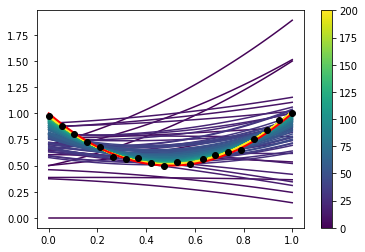

In [11]:
cmap = plt.cm.viridis
plot_curve(cmap(0))
n_iters = 200
for i in range(n_iters):
    loss = th.sum((y - model(x, *param))**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    plot_curve(cmap((i + 1) / n_iters))
plt.scatter(x.detach(), y.detach(), color='black', zorder=100)
x_plt = th.linspace(0, 1, 1000)
plt.plot(x_plt, model(x_plt, 1, -2, 2), linewidth=2, color='red') # actual model
plt.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=0, vmax=200), cmap=cmap))
plt.show()

After 200 epochs or iterations, the curve has converged to the actual model (in red).

# References

- https://pytorch.org/docs/stable/optim.html
- https://en.wikipedia.org/wiki/Gradient_descent
- https://en.wikipedia.org/wiki/Least_squares